# Examining Cloud Information in the RRFS Ensemble

shawn.s.murdzek@noaa.gov

Machine: Jet  
Environment: adb_graphics

### General Notes:
- I recommend omitting postage stamp plots for large domains, as these plots take considerable time and memory to generate

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import yaml
import metpy.calc as mc
from metpy.units import units
import metpy.constants as const

import pyDA_utils.plot_model_data as pmd
import pyDA_utils.bufr as bufr
import pyDA_utils.ensemble_utils as eu

In [16]:
from importlib import reload
eu = reload(eu)

# Input Parameters

In [9]:
"""
Read Input Parameters
"""

case = 'CONUS_2022020113'
yml_fname = '/lfs4/BMC/wrfruc/murdzek/src/py_scripts/cloud_da/cases/{c}/{c}_input.yml'.format(c=case)
with open(yml_fname, 'r') as fptr:
    param = yaml.safe_load(fptr)

# UPP output for each ensemble member
str_format = param['str_format']
prslev_fnames = {}
natlev_fnames = {}
for i in range(1, param['nmem']+1):
    prslev_fnames['mem{num:04d}'.format(num=i)] = str_format.format(num=i, lev='prslev')
    natlev_fnames['mem{num:04d}'.format(num=i)] = str_format.format(num=i, lev='natlev')
prslev_vars = param['prslev_vars']

# BUFR file name
bufr_fname = param['bufr_fname']

# Subset domain
min_lon = param['min_lon']
max_lon = param['max_lon']
min_lat = param['min_lat']
max_lat = param['max_lat']
z_ind = param['z_ind']

# Variables to include in state matrix (assumed to be 3D)
state_vars = param['state_vars']

# Tag for output files
save_tag = param['save_tag']
out_dir = param['out_dir']

# Marker size for spatial rank plots
msize = param['msize']

# "Target" (lat, lon) coordinate for BEC spatial plots
do_bec = param['do_bec']
bec_lat = param['bec_lat']
bec_lon = param['bec_lon']
bec_klvl = param['bec_klvl']

# Read in Ensemble and BUFR Output

In [3]:
"""
Read in ensemble output and BUFR obs
"""

start = dt.datetime.now()
ens_obj = eu.ensemble(natlev_fnames, extra_fnames=prslev_fnames, extra_fields=prslev_vars, 
                      bufr_csv_fname=bufr_fname, lat_limits=[min_lat, max_lat], lon_limits=[min_lon, max_lon],
                      zind=z_ind, state_fields=state_vars, bec=do_bec)
print('elapsed time = {t:.2f} s'.format(t=(dt.datetime.now() - start).total_seconds()))
print('Shape of subset =', ens_obj.subset_ds['mem0001']['TMP_P0_L105_GLC0'].shape)

reading member mem0001
reading member mem0002
reading member mem0003
reading member mem0004
reading member mem0005
reading member mem0006
reading member mem0007
reading member mem0008
reading member mem0009
reading member mem0010
reading member mem0011
reading member mem0012
reading member mem0013
reading member mem0014
reading member mem0015
reading member mem0016
reading member mem0017
reading member mem0018
reading member mem0019
reading member mem0020
reading member mem0021
reading member mem0022
reading member mem0023
reading member mem0024
reading member mem0025
reading member mem0026
reading member mem0027
reading member mem0028
reading member mem0029
reading member mem0030


/contrib/miniconda3/4.5.12/envs/adb_graphics/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


elapsed time = 631.77 s
Shape of subset = (1, 1058, 1798)


# Plotting Cells

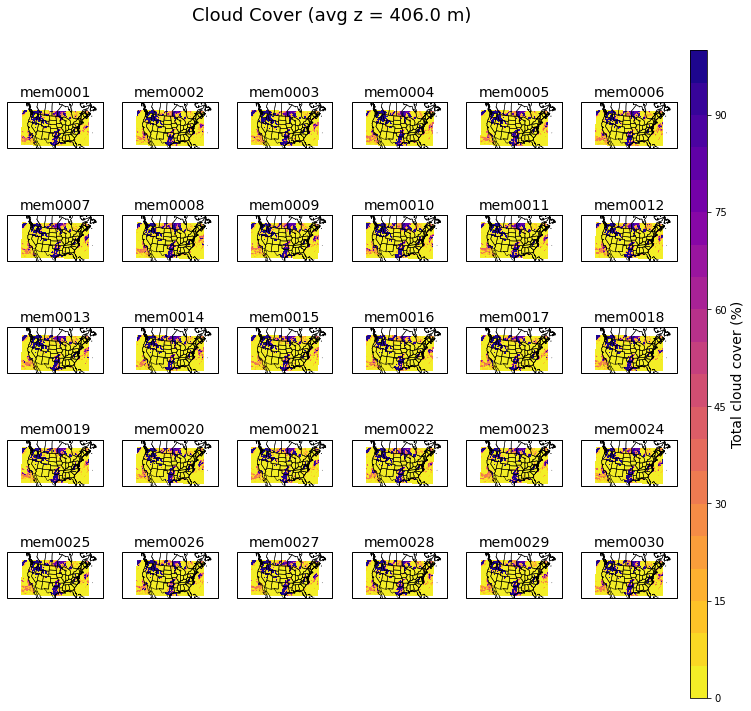

In [4]:
"""
Make horizontal cross section postage stamp plots: Cloud Cover at a Single Vertical Level
"""

# Field name and colorbar limits/colormap. Set klvl to NaN if 2D field
upp_field = 'TCDC_P0_L105_GLC0'
save_fname = '{d}/postage_stamp_cloud_cover_{tag}.png'.format(d=out_dir, tag=save_tag)
title = 'Cloud Cover'
klvl = 0
cmap = 'plasma_r'
clevels = np.arange(0, 100.1, 5)
extend = 'neither'

nrows = 5
ncols = 6
figsize = (12, 10)

###

# Make plot

fig = ens_obj.postage_stamp_contourf(upp_field, nrows, ncols, klvl=klvl, figsize=figsize, title=title,
                                     plt_kw={'ingest_kw':{'zind':[klvl]}, 
                                             'cntf_kw':{'cmap':cmap, 'levels':clevels, 'extend':extend}})

plt.savefig(save_fname)

In [ ]:
"""
Make horizontal cross section postage stamp plots: Ceilings (with BUFR obs)
"""

# Field name and colorbar limits/colormap. Set klvl to NaN if 2D field
upp_field = 'HGT_P0_L215_GLC0'
save_fname = '{d}/postage_stamp_ceil_{tag}.png'.format(d=out_dir, tag=save_tag)
title = 'Legacy Ceiling Diagnostic'
klvl = np.nan
cmap = 'plasma'
clevels = np.arange(0, 1000.1, 100)
extend = 'max'

bufr_field = 'CEILING'
bufr_subset = ['ADPSFC']
bufr_nonan = 'TOB'     # Only use a row if this obs is not NaN

nrows = 5
ncols = 6
figsize = (12, 10)

###

# Make plot

fig = ens_obj.postage_stamp_contourf(upp_field, nrows, ncols, klvl=klvl, figsize=figsize, title=title,
                                     plt_kw={'ingest_kw':{'zind':[klvl]}, 
                                             'cntf_kw':{'cmap':cmap, 'levels':clevels, 'extend':extend}})
ens_obj.plot_bufr_obs(fig.get_axes()[:-1], bufr_field, bufr_subset, bufr_nonan, 
                      scatter_kw={'cmap':cmap, 'vmin':clevels[0], 'vmax':clevels[-1], 
                                  'edgecolors':'k', 'linewidths':0.75, 's':50})

plt.savefig(save_fname)

In [ ]:
"""
Plot Ensemble Mean and Standard Deviation
"""

# Field name and colorbar limits/colormap. Set klvl to NaN if 2D field
upp_field = 'TCDC_P0_L105_GLC0'
save_fname = '{d}/ens_mean_std_{tag}.png'.format(d=out_dir, tag=save_tag)
title = 'Cloud Cover'
klvl = 0
cmap = 'plasma_r'
vmin = 0
vmax = 100
extend = 'neither'

nrows = 1
ncols = 2
figsize = (8, 5)

###

# Make plot
fig = plt.figure(figsize=figsize)
for i, stat in enumerate(['mean', 'std']):
    ax = ens_obj.plot_state_vector(stat, upp_field, fig, nrows, ncols, i+1, zind=klvl, 
                                   pcm_kw={'cmap':cmap, 'vmin':vmin, 'vmax':vmax})


plt.suptitle(title, size=20)
plt.savefig(save_fname)

In [ ]:
"""
Plot Spatial Distributions of BECs For a Particular Gridpoint and Variable
"""

# Coordinate of point to plot BECs in relation to (this is the "target" point)
var = 'TCDC_P0_L105_GLC0'
plot_klvl = bec_klvl
save_fname = '{d}/BEC_spatial_dist_{tag}.png'.format(d=out_dir, tag=save_tag)

###

if do_bec:

    # Determine gridpoint closest to the target (lat, lon) coordinate
    tmp_ds = ens_obj.subset_ds[ens_obj.mem_names[0]]
    lat_all = tmp_ds['gridlat_0'].values
    lon_all = tmp_ds['gridlon_0'].values
    target_i, target_j = np.unravel_index(np.argmin((lat_all - bec_lat)**2 + (lon_all - bec_lon)**2), lon_all.shape)

    # Determine indices corresponding with the target variable and location
    target_var_idx = np.where(ens_obj.state_matrix['vars'] == var)[0]
    target_idx = target_var_idx[0] + np.ravel_multi_index([[bec_klvl], [target_i], [target_j]], 
                                                          tmp_ds[var].shape)

    # Make plot
    fig = plt.figure(figsize=(12, 7.5))
    for i, v in enumerate(state_vars):
        ax = ens_obj.plot_state_vector('be_cov', v, fig, 1, len(state_vars), i+1, zind=plot_klvl,
                                       bec_idx=target_idx, ctr_cmap_0=True,
                                       pcm_kw={'cmap':'bwr', 'vmin':vmin, 'vmax':vmax},
                                       cbar_kw={'orientation':'horizontal'})
        ax.plot(lon_all[target_i, target_j], lat_all[target_i, target_j], 'k*', ms=10, transform=ccrs.PlateCarree())

    plt.savefig(save_fname)

In [ ]:
"""
Plot Histograms of Deviations from Ensemble Mean
"""

save_fname = '{d}/error_hist_{tag}.png'.format(d=out_dir, tag=save_tag)

###

fig, axes = plt.subplots(nrows=1, ncols=len(state_vars), figsize=(12, 6))
plt.subplots_adjust(left=0.1, bottom=0.08, right=0.99, top=0.88, wspace=0.2)
for i, v in enumerate(state_vars):
    axes[i] = ens_obj.plot_ens_dev_hist(v, axes[i], hist_kw={'bins':50})

axes[0].set_ylabel('counts', size=14)
plt.suptitle('Deviations from the Ensemble Mean', size=22)
plt.savefig(save_fname)

In [ ]:
"""
Plot Rank For Each Ceiling Ob
"""

model_fields = ['HGT_P0_L215_GLC0', 'CEIL_P0_L215_GLC0', 'CEIL_P0_L2_GLC0', 'HGT_P0_L2_GLC0']
ceiling_name = ['ceiling', 'ceil_exp1', 'ceil_exp2', 'cld_base']
klvl = np.nan
save_fname_spatial = ['{d}/{ceil}_ranks_%s_{tag}.png'.format(d=out_dir, tag=save_tag, ceil=c) for c in ceiling_name]
save_fname_hist = ['{d}/{ceil}_ranks_%s_hist_{tag}.png'.format(d=out_dir, tag=save_tag, ceil=c) for c in ceiling_name]
save_fname_txt = '{d}/ceiling_stats_{tag}.txt'.format(d=out_dir, tag=save_tag)

bufr_field = 'CEILING'
bufr_subset = ['ADPSFC']
bufr_nonan = 'TOB'     # Only use a row if this ob is not NaN

###

out_fptr = open(save_fname_txt, 'w')

for mfield, fname_spatial, fname_hist in zip(model_fields, save_fname_spatial, save_fname_hist):

    print()
    print('----------------------------')
    print('Field = {f}'.format(f=mfield))
    print()
    out_fptr.write('\n----------------------------')
    out_fptr.write('Field = {f}'.format(f=mfield))
    start = dt.datetime.now()

    # Interpolate ensemble members to ob locations
    subset_obs = ens_obj._subset_bufr(bufr_subset, bufr_nonan)
    ens_interp = ens_obj.interp_model_2d(mfield, subset_obs['YOB'].values, subset_obs['XOB'].values-360., 
                                         zind=klvl, method='nearest', verbose=True)

    # Compute height from geopotential height
    ob_vals = subset_obs[bufr_field].values
    ens_vals = mc.geopotential_to_height(ens_interp.loc[:, ens_obj.mem_names].values * units.m * const.g).to('m').magnitude

    # Change NaNs to be an arbitrarily large number
    ob_vals[np.isnan(ob_vals)] = 1e8
    ens_vals[np.isnan(ens_vals)] = 1e9

    # Determine ranks
    ranks = np.zeros(len(subset_obs))
    for i in range(len(ranks)):
        ranks[i] = np.sum(ob_vals[i] > ens_vals[i, :])
    
    # Partitioning: Correct nulls (neither obs nor ensemble has a ceiling)
    correct_nulls = np.sum(np.logical_and(np.isclose(ob_vals, 1e8),
                                          np.all(np.isclose(ens_vals, 1e9), axis=1)))
    print('correct null ceilings = {nulls} (out of {tot})'.format(nulls=correct_nulls, tot=len(ob_vals)))
    out_fptr.write('correct null ceilings = {nulls} (out of {tot})'.format(nulls=correct_nulls, tot=len(ob_vals)))
    
    # Partitioning: Missed ceilings (obs has ceiling but ensemble doesn't)
    misses = np.sum(np.logical_and(~np.isclose(ob_vals, 1e8),
                                   np.all(np.isclose(ens_vals, 1e9), axis=1)))
    print('missed ceilings = {misses} (out of {tot})'.format(misses=misses, tot=len(ob_vals)))
    out_fptr.write('missed ceilings = {misses} (out of {tot})'.format(misses=misses, tot=len(ob_vals)))

    # Partitioning: False alarm ceilings (ensemble has ceiling, but obs do not)
    falarm = np.sum(np.logical_and(np.isclose(ob_vals, 1e8),
                                   ~np.all(np.isclose(ens_vals, 1e9), axis=1)))
    print('false alarm = {falarm} (out of {tot})'.format(falarm=falarm, tot=len(ob_vals)))
    out_fptr.write('false alarm ceilings = {falarm} (out of {tot})'.format(falarm=falarm, tot=len(ob_vals)))
    
    # Partitioning: Hits (both obs and ensemble have a ceiling)
    hit_idx = np.where(np.logical_and(~np.isclose(ob_vals, 1e8),
                                      ~np.all(np.isclose(ens_vals, 1e9), axis=1)))[0]
    hits = len(hit_idx)
    print('hit ceilings = {hits} (out of {tot})'.format(hits=hits, tot=len(ob_vals)))
    out_fptr.write('hit ceilings = {hits} (out of {tot})'.format(hits=hits, tot=len(ob_vals)))
    
    # Make plots
    for idx, tag in zip([np.where(np.ones(ranks.size))[0], hit_idx], ['all', 'hits']):
        
        rank_subset = ranks[idx]
        
        # Plot ranks: Spatial plot
        print('making plots')
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal())
        for i in range(len(rank_subset)):
            if rank_subset[i] == 0:
                m = 'v'
            elif rank_subset[i] == param['nmem']:
                m = '^'
            else:
                m = 'o'
            cax = ax.scatter(subset_obs.loc[i, 'XOB'], subset_obs.loc[i, 'YOB'], c=rank_subset[i], 
                             s=msize, cmap='bwr', vmin=0, vmax=param['nmem'], marker=m, linewidths=1, edgecolors='k',
                             transform=ccrs.PlateCarree(), alpha=1)

        ax.set_title('Ob field: {ob_f}, Model field: {m_f}\n'.format(ob_f=bufr_field, m_f=mfield) +
                     'down triangle: rank 0, up triangle: rank {rmax}'.format(rmax=param['nmem']), size=20)
        ax.set_extent([min_lon, max_lon, min_lat, max_lat])
        ax.coastlines('50m', edgecolor='gray', linewidth=0.25)
        borders = cfeature.NaturalEarthFeature(category='cultural',
                                                scale='50m',
                                               facecolor='none',
                                               name='admin_1_states_provinces')
        ax.add_feature(borders, linewidth=0.25, edgecolor='gray')
        #lakes = cfeature.NaturalEarthFeature(category='physical',
        #                                     scale='50m',
        #                                     facecolor='none',
        #                                     name='lakes')
        #ax.add_feature(lakes, linewidth=0.25, edgecolor='gray')

        cbar = plt.colorbar(cax, ax=ax, orientation='horizontal', pad=0.02, aspect=25)
        cbar.set_label('Ob rank', size=16)
        plt.savefig(fname_spatial % tag)

        # Plot ranks: Histogram
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
        ax.hist(rank_subset, bins=np.arange(0, param['nmem']+2), edgecolor='k', linewidth=1)
        ax.set_title('Rank Histogram: {v} (n = {n})'.format(v=bufr_field, n=len(rank_subset)), size=18)
        ax.set_xlabel('rank', size=14)
        ax.set_ylabel('count', size=14)
        ax.grid(axis='y')
        ax.set_xlim([0, param['nmem']+1])
        plt.savefig(fname_hist % tag)

    print('elapsed time = {t:.2f} s'.format(t=(dt.datetime.now() - start).total_seconds()))
    
out_fptr.close()


----------------------------
Field = HGT_P0_L215_GLC0

Performing interpolation for mem0001
Performing interpolation for mem0002
Performing interpolation for mem0003
Performing interpolation for mem0004
Performing interpolation for mem0005
Performing interpolation for mem0006
Performing interpolation for mem0007
Performing interpolation for mem0008
Performing interpolation for mem0009
Performing interpolation for mem0010
Performing interpolation for mem0011
Performing interpolation for mem0012
Performing interpolation for mem0013
Performing interpolation for mem0014
Performing interpolation for mem0015
Performing interpolation for mem0016
Performing interpolation for mem0017
Performing interpolation for mem0018
Performing interpolation for mem0019
Performing interpolation for mem0020
Performing interpolation for mem0021
Performing interpolation for mem0022
Performing interpolation for mem0023
Performing interpolation for mem0024
Performing interpolation for mem0025
Performing interpol